# Text Transfer learning
Based on the quick learning from fastai

In [ ]:
from fastai.text.all import *

## Training a text classifier from a pretrained model
### About Dataset
- [IMDB Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)

- Contains 25k Training and 25k for testing.
- Contains seperate folder for negative and positive reviews in each training and testing folders.

In [ ]:
imdbPath = untar_data(URLs.IMDB)
imdbPath.ls()

In [4]:
(imdbPath/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/labeledBow.feat'),Path('/root/.fastai/data/imdb/train/pos')]

In [7]:
imdbDls = TextDataLoaders.from_folder(imdbPath, valid = 'test')
# Validation folder is 'test' whereas default used in DataLoaders is 'valid'

In [8]:
imdbDls.show_batch()

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n\n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older adventure movies has been done well before , ( think _ the xxmaj dirty xxmaj dozen _ ) but _ atlantis _ represents one of the worse films in that motif . xxmaj the characters are weak . xxmaj even the background that each member trots out seems stock and awkward at best . xxmaj an xxup md / xxmaj medicine xxmaj man , a tomboy mechanic whose father always wanted sons , if we have not at least seen these before",neg
2,"xxbos xxrep 3 * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . xxrep 3 * \n\n xxmaj before i begin , xxmaj i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that - you - fall - over - laughing movies . xxmaj if you 're in a lighthearted mood and need a very hearty laugh , this is the movie for you . xxmaj now without further ado , my review : \n\n xxmaj this movie was found in a bargain bin at wal - mart . xxmaj that should be the first clue as to how good of a movie it is . xxmaj secondly , it stars the lame action",neg
3,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the oddest possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is innate , contained within the characters and the setting and the plot … which is highly believable to boot . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",pos
4,"xxbos xxmaj billy xxmaj chung xxmaj siu xxmaj hung 's ( the bloody swordplay film xxmaj assassin from 1993 ) film xxmaj love xxmaj to xxmaj kill ( hong xxmaj kong , 1993 ) is among the strongest products of the xxmaj category xxrep 3 i boom that inhabited the xxup hk cinema in early nineties . xxmaj it consisted of films with strong sex , nudity and violence , more or less gratuitous and shock valued only . xxmaj love xxmaj to xxmaj kill definitely belongs to the "" more "" category with some unforgettable ideas and pieces of celluloid sickness . \n\n xxmaj the xxup hk psycho xxmaj anthony xxmaj wong ( from the award winning xxmaj the xxmaj untold xxmaj story by xxmaj herman xxmaj yau , from the same year ) plays a business man and a husband who likes to torture , humiliate and rape",neg
5,"xxbos xxmaj the vigilante has long held a fascination for audiences , inasmuch as it evokes a sense of swift , sure justice ; good triumphs over evil and the bad guy gets his desert

### Text learner
AWD_LSTM is an architechture we'd be using for our text_classifier.
LSTM is Long Short Term Memory\
It's a language model but with the help of trasfer learning; we are using it for review classifiew

In [9]:
reviewLearner = text_classifier_learner(imdbDls, AWD_LSTM, drop_mult = 0.5, metrics = accuracy)

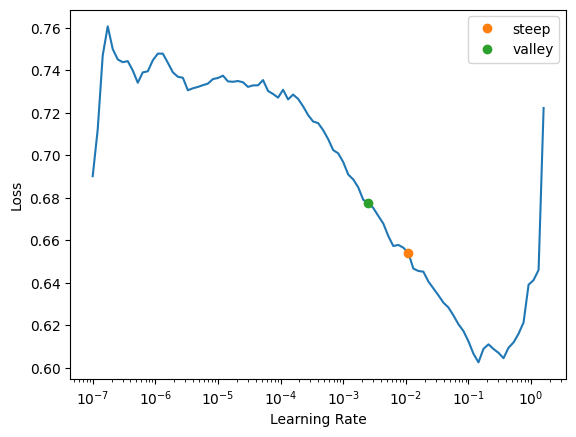

In [11]:
lrate = reviewLearner.lr_find(suggest_funcs= (steep, valley))

In [12]:
reviewLearner.fine_tune(5, lrate.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.466211,0.391640,0.823480,03:30


epoch,train_loss,valid_loss,accuracy,time
0,0.351052,0.294302,0.877200,07:34
1,0.287262,0.253326,0.899400,07:36
2,0.247053,0.215733,0.916360,07:35
3,0.223084,0.211623,0.917840,07:34
4,0.199622,0.209510,0.918320,07:34


# The ULMFiT approach
Since the AWD_LSTM pretrained model has been trained with wikipedia english which is different that the english used in the IMDB reviews we will be taking two step approach to create a classifier
1. #### Turn wiki language model into IMDb language model
We will use the non categorised additional text dataset supplied to create IMDb Language model
2. #### Turn the IMDb Language model into review classifier
Fine tune the model to classifier using the labelled dataset

## IMDb Language Model

In [14]:
dls_lm = TextDataLoaders.from_folder(imdbPath, is_lm = True, valid_pct = 0.1)
dls_lm.show_batch(max_n=5)

,text,text_
0,xxbos ( some xxmaj spoilers ) xxup prc quickie that has xxup j. xxmaj carrol xxmaj naish playing xxmaj dr . xxmaj igor xxmaj markoff who 's not really xxmaj dr . xxmaj xxunk but an impostor who took over his identity back in xxmaj europe . \n\n xxmaj the real xxmaj dr . xxmaj xxunk had a affair with xxunk 's wife that lead to him to murder the real xxunk,( some xxmaj spoilers ) xxup prc quickie that has xxup j. xxmaj carrol xxmaj naish playing xxmaj dr . xxmaj igor xxmaj markoff who 's not really xxmaj dr . xxmaj xxunk but an impostor who took over his identity back in xxmaj europe . \n\n xxmaj the real xxmaj dr . xxmaj xxunk had a affair with xxunk 's wife that lead to him to murder the real xxunk and
1,xxmaj hall \n\n xxmaj bless the independent filmmaker . xxmaj without them we 'd see nothing but xxmaj spielberg the xxmaj farrelly brothers and films based on old sitcoms . xxmaj they are the risk takers . xxmaj they reap the rewards of success and suffer the failures . xxmaj max and xxmaj grace is most definitely a failure . xxmaj credit is deserved by xxmaj michael xxmaj parness for getting out,hall \n\n xxmaj bless the independent filmmaker . xxmaj without them we 'd see nothing but xxmaj spielberg the xxmaj farrelly brothers and films based on old sitcoms . xxmaj they are the risk takers . xxmaj they reap the rewards of success and suffer the failures . xxmaj max and xxmaj grace is most definitely a failure . xxmaj credit is deserved by xxmaj michael xxmaj parness for getting out there
2,"9 / 10 stars , this reviewer xxup highly recommends it to all potential viewers ! xxbos xxmaj this movie lacks one thing . xxmaj do you know what this is ? xxmaj brains ! xxmaj in one scene a little boy is riding his bike up a hill , but the bike is carrying a bath tub and a seal in the bath tub ! i do n't think xxmaj hulk","/ 10 stars , this reviewer xxup highly recommends it to all potential viewers ! xxbos xxmaj this movie lacks one thing . xxmaj do you know what this is ? xxmaj brains ! xxmaj in one scene a little boy is riding his bike up a hill , but the bike is carrying a bath tub and a seal in the bath tub ! i do n't think xxmaj hulk could"
3,"laura xxmaj dern ) ends up handling the situation . \n\n xxmaj having said that , i still enjoyed this movie very much . xxmaj it 's raised my assessment of xxmaj sean xxmaj penn 's acting abilities and i would recommend it to others and would watch it again . \n\n 7 / 10 xxbos xxmaj goldie xxmaj hawn has never been a favorite , i must admit , but that","xxmaj dern ) ends up handling the situation . \n\n xxmaj having said that , i still enjoyed this movie very much . xxmaj it 's raised my assessment of xxmaj sean xxmaj penn 's acting abilities and i would recommend it to others and would watch it again . \n\n 7 / 10 xxbos xxmaj goldie xxmaj hawn has never been a favorite , i must admit , but that is"
4,"mind you , but definitely fun enough . xxmaj as a spoof of the shallow conceit that is xxmaj hollywood , it 's only so - so ; as a horror movie it 's also only fair . xxmaj and even as just a simple vintage exploitation picture , it 's just xxup ok . xxmaj i 'm a big fan of the unnecessary gratuitous dance sequence , so i was also","you , but definitely fun enough . xxmaj as a spoof of the shallow conceit that is xxmaj hollywood , it 's only so - so ; as a horror movie it 's also only fair . xxmaj and even as just a simple vintage exploitation picture , it 's just xxup ok . xxmaj i 'm a big fan of the unnecessary gratuitous dance sequence , so i was also thankful"


In [19]:
imdbLangLearner = language_model_learner(dls_lm, AWD_LSTM, metrics = [accuracy, Perplexity()], path = imdbPath, wd=0.1).to_fp16()

*Behind the scenes of fine tuning*\
The model is in frozen state, only head of the model can be trained while body stays frozen

In [20]:
imdbLangLearner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.387368,4.113480,0.286102,61.159187,26:23


In [21]:
# saving the state of the model
imdbLangLearner.save('1epoch')

Path('/root/.fastai/data/imdb/models/1epoch.pth')

In [22]:
# Reload the saved model
imdbLangLearner = imdbLangLearner.load('1epoch')

In [23]:
imdbLangLearner.unfreeze()
imdbLangLearner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time


KeyboardInterrupt: 

We will save the model without the final layer which converts the activation into probabilities of picking each token in our vocabulary.
The model which is not including the final layer is called the encoder.

In [ ]:
imdbLangLearner.save_encoder('finetuned')

# Encoder: The model not including the task-specific final layer(s).
# It means much the same thing as body when applied to vision CNNs,
# but tends to be more used for NLP and generative models.

We just fine tuned LLM based on the IMDb Dataset. We can know predict the next word in sentences and use it to write reviews

In [ ]:
TEXT = 'I did not liked this movie because'
N_WORDS = 40
N_SENTENCES = 50
preds = [imdbLangLearner.predict(TEXT, N_WORDS, temperature = 0.75) for _ in range(N_SENTENCES)]
# Temperature is often set in the range of 0-2 where lower number generates more deterministic responses


In [ ]:
print("\n".join(preds))

## Fine Tuning Review Classifier


In [ ]:
# Taking a peek at dls_lm vocab
dls_lm.vocab

In [ ]:
# Main difference is that we
dls_classifier = TextDataLoader.from_folder(imdbPath, valid = 'test',
                                            text_vocab = dls_lm.vocab)

In [ ]:
imdbReviewLearner = text_classifier_learner(dls_classifier,
                                            AWD_LSTM,
                                            drop_mult = 0.5,
                                            metrics = accuracy)

In [ ]:
imdbReviewLearner = imdbReviewLearner.load_encoder('finetune')